# Comparing runs using `MAF` metrics previously calculated in bulk

## Introduction

This notebook demonstrates some ways to examine, analyze, and compare metrics computed by `MAF` and saved to disk.

It assums the `Computing Metrics in Bulk` notebook has been run, and that the `data_dir` variable will be set to the same directory it was for that notebook.

## Notebook preparation

The following is a development style aid; only uncomment if developing the notebook:

In [1]:
# %load_ext lab_black
# %load_ext pycodestyle_magic
# %flake8_on --ignore E501,W505

Import modules used by this notebook:

In [2]:
import rubin_sim
from rubin_sim import maf

Loading BokehJS ...

## Set the storage directory for this notebook

Set the directory in which to look for metrics already computed.

In [3]:
from os import path
from os import getcwd

data_dir = path.join(getcwd(), "bulk_metric_data")

# Building a list of data directories and run names

The first thing you need to do is build a list of run names you want to look at, if you don't know them a priori.

You will always need a list of directories in which to look for data, so let's look through our directories for MAF metric output, and extract run names from it.

In [4]:
import pandas as pd
import os


def find_data(data_dirs):
    # Support getting either just one or an iterable
    # of directories
    if isinstance(data_dirs, str):
        data_dirs = [data_dirs]

    all_run_list = []
    for data_dir in data_dirs:
        for dirpath, dirnames, filenames in os.walk(data_dir):
            if "resultsDb_sqlite.db" in filenames:
                results_db = maf.ResultsDb(outDir=dirpath)
                these_runs = pd.read_sql(
                    "SELECT DISTINCT simDataName FROM metrics",
                    results_db.session.connection(),
                )
                these_runs["outDir"] = dirpath
                all_run_list.append(these_runs)

    all_runs = pd.concat(all_run_list)
    return all_runs


maf_data = find_data(data_dir)
maf_data

,simDataName,outDir
0,baseline_nexp2_v1.7_10yrs,/data/des91.b/data/neilsen/LSST/devel/rubin_si...
0,baseline_2snaps_v1.5_10yrs,/data/des91.b/data/neilsen/LSST/devel/rubin_si...
0,baseline_v2.0_10yrs,/data/des91.b/data/neilsen/LSST/devel/rubin_si...
0,long_gaps_nightsoff3_delayed_1_v2.0_10yrs,/data/des91.b/data/neilsen/LSST/devel/rubin_si...
0,footprint_4_v1.710yrs,/data/des91.b/data/neilsen/LSST/devel/rubin_si...
0,rolling_ns3_rw0.9_v2.0_10yrs,/data/des91.b/data/neilsen/LSST/devel/rubin_si...


If you want to use a subset of runs, you can limit the data found to just those:

In [5]:
use_all_runs = True
if not use_all_runs:
    wanted_runs = [
        "baseline_2snaps_v1.5_10yrs",
        "footprint_4_v1.710yrs",
        "baseline_nexp2_v1.7_10yrs",
    ]
    maf_data = maf_data.set_index("simDataName").loc[wanted_runs].reset_index()

# Seeing what data you've got

Let's take a look at what we have. This requires iterating over the data from each results database.

## Finding the metrics that have been calculated

Iterate through each row of the `maf_data` `DataFrame`, and extract the run name and its directory from each row.

Then, create an interface to the results database in each director by instantiting a `maf.ResultsDb` object, query it for the metrics it has for the relevant run, and use it to retrieve the metadata of each metric present for that run.

Store the results for all found metrics in a `pandas.DataFrame` that can be examined visually or queried later.

In [6]:
metric_df_list = []

# Iterate through each row of the maf_data
for _, run_result_meta in maf_data.iterrows():
    # Extract the run and dirctory from each row of the DataFrame
    run_name = run_result_meta.simDataName
    out_dir = run_result_meta.outDir

    # Create an interface to the results database
    # in the specified directory
    results_db = maf.ResultsDb(outDir=out_dir)

    # Read the numeric metric ids for metrics on the run we want
    metric_ids = results_db.getMetricIdLike(simDataName=run_name)

    # Read the metric metadata for the run we want from the database.
    # For results databases created by the Compute Metrics in Bulk database,
    # there should only be data for the one run in each database,
    # but this is not guaranteed in general.
    metric_df = pd.DataFrame(results_db.getMetricInfo(metricId=metric_ids, withSimName=True))

    # We will be combining all runs into the same
    # dataframe, so all columns to let us distinguish
    # what came from where.
    metric_df["outDir"] = out_dir
    metric_df_list.append(metric_df)

metric_df = pd.concat(metric_df_list)
metric_df

,metricId,metricName,baseMetricNames,slicerName,sqlConstraint,metricMetadata,metricDataFile,simDataName,outDir
0,1,OpenShutterFraction,OpenShutterFraction,UniSlicer,,,baseline_nexp2_v1_7_10yrs_OpenShutterFraction_...,baseline_nexp2_v1.7_10yrs,/data/des91.b/data/neilsen/LSST/devel/rubin_si...
1,2,Count airmass,Count airmass,OneDSlicer,,,baseline_nexp2_v1_7_10yrs_Count_airmass_ONED.npz,baseline_nexp2_v1.7_10yrs,/data/des91.b/data/neilsen/LSST/devel/rubin_si...
2,3,CoaddM5,CoaddM5,HealpixSlicer,filter = 'i',i,baseline_nexp2_v1_7_10yrs_CoaddM5_i_HEAL.npz,baseline_nexp2_v1.7_10yrs,/data/des91.b/data/neilsen/LSST/devel/rubin_si...
3,4,CoaddM5,CoaddM5,HealpixSlicer,filter = 'g',g,baseline_nexp2_v1_7_10yrs_CoaddM5_g_HEAL.npz,baseline_nexp2_v1.7_10yrs,/data/des91.b/data/neilsen/LSST/devel/rubin_si...
0,1,OpenShutterFraction,OpenShutterFraction,UniSlicer,,,baseline_2snaps_v1_5_10yrs_OpenShutterFraction...,baseline_2snaps_v1.5_10yrs,/data/des91.b/data/neilsen/LSST/devel/rubin_si...
1,2,Count airmass,Count airmass,OneDSlicer,,,baseline_2snaps_v1_5_10yrs_Count_airmass_ONED.npz,baseline_2snaps_v1.5_10yrs,/data/des91.b/data/neilsen/LSST/devel/rubin_si...
2,3,CoaddM5,CoaddM5,HealpixSlicer,filter = 'i',i,baseline_2snaps_v1_5_10yrs_CoaddM5_i_HEAL.npz,baseline_2snaps_v1.5_10yrs,/data/des91.b/data/neilsen/LSST/devel/rubin_si...
3,4,CoaddM5,CoaddM5,HealpixSlicer,filter = 'g',g,baseline_2snaps_v1_5_10yrs_CoaddM5_g_HEAL.npz,baseline_2snaps_v1.5_10yrs,/data/des91.b/data/neilsen/LSST/devel/rubin_si...
0,1,OpenShutterFraction,OpenShutterFraction,UniSlicer,,,baseline_v2_0_10yrs_OpenShutterFraction_UNIS.npz,baseline_v2.0_10yrs,/data/des91.b/data/neilsen/LSST/devel/rubin_si...
1,2,Count airmass,Count airmass,OneDSlicer,,,baseline_v2_0_10yrs_Count_airmass_ONED.npz,baseline_v2.0_10yrs,/data/des91.b/data/neilsen/LSST/devel/rubin_si...


# Examining summary statistics for one run

The results database also contains all of the summary statistics. 

If you have a run for which you want statistics:

In [7]:
run_name = "baseline_v2.0_10yrs"

begin by querying the `maf_data` `DataFrame` for the directory:

In [8]:
out_dir = maf_data.set_index("simDataName").loc[run_name, "outDir"]
out_dir

'/data/des91.b/data/neilsen/LSST/devel/rubin_sim_notebooks/maf/tutorial/bulk_metric_data/baseline_v2.0_10yrs/bulk_example'

Now, create our instance of `ResultsDB` to serve as an interface:

In [9]:
results_db = maf.ResultsDb(outDir=out_dir)

Take a look at the summary statistics recorded in this specific results database, turning it into a `pandas.DataFrame` for easier viewing:

In [10]:
sum_stats = pd.DataFrame(results_db.getSummaryStats(withSimName=True))
sum_stats.head()

,metricId,metricName,slicerName,metricMetadata,summaryName,summaryValue,simDataName
0,1,OpenShutterFraction,UniSlicer,,Identity,0.722458,baseline_v2.0_10yrs
1,2,Count airmass,OneDSlicer,,Mean,69566.000000,baseline_v2.0_10yrs
2,2,Count airmass,OneDSlicer,,Rms,103403.912924,baseline_v2.0_10yrs
3,2,Count airmass,OneDSlicer,,Median,13391.500000,baseline_v2.0_10yrs
4,2,Count airmass,OneDSlicer,,Max,365361.000000,baseline_v2.0_10yrs


In this example there is only one run in the database, but in general we need to select on the run name to make sure we are getting the stats for just the run we want:

In [11]:
sum_stats = sum_stats.query(f'simDataName == "{run_name}"')
sum_stats

,metricId,metricName,slicerName,metricMetadata,summaryName,summaryValue,simDataName
0,1,OpenShutterFraction,UniSlicer,,Identity,0.722458,baseline_v2.0_10yrs
1,2,Count airmass,OneDSlicer,,Mean,69566.000000,baseline_v2.0_10yrs
2,2,Count airmass,OneDSlicer,,Rms,103403.912924,baseline_v2.0_10yrs
3,2,Count airmass,OneDSlicer,,Median,13391.500000,baseline_v2.0_10yrs
4,2,Count airmass,OneDSlicer,,Max,365361.000000,baseline_v2.0_10yrs
5,2,Count airmass,OneDSlicer,,Min,831.000000,baseline_v2.0_10yrs
6,2,Count airmass,OneDSlicer,,N(+3Sigma),0.000000,baseline_v2.0_10yrs
7,2,Count airmass,OneDSlicer,,N(-3Sigma),0.000000,baseline_v2.0_10yrs
8,2,Count airmass,OneDSlicer,,Count,30.000000,baseline_v2.0_10yrs
9,2,Count airmass,OneDSlicer,,25th%ile,3339.000000,baseline_v2.0_10yrs


# Looking at a plot you've made already

The names of the files into which plots were saved are recorded in the `ResultsDB`. So, we can use an instance of a `ResultsDB` to see what we made, and then build the full file name and show the plot:

As above, grab a sample `out_dir` from our list of data, and instantiate a `ResultsDB`:

Repeat the procedure followed for the summary statistics example to get an instance of `ResultsDB` to the relevant results database:

In [12]:
run_name = "baseline_v2.0_10yrs"
out_dir = maf_data.set_index("simDataName").loc[run_name, "outDir"]
results_db = maf.ResultsDb(outDir=out_dir)

Query the plot metadata from the results database and convert it to a `pandas.DataFrame` for easy viewing:

In [13]:
import pandas as pd


plot_files = pd.DataFrame(results_db.getPlotFiles(withSimName=True))
plot_files

,metricId,metricName,metricMetadata,plotType,plotFile,thumbFile,simDataName
0,2,Count airmass,,BinnedData,baseline_v2_0_10yrs_Count_airmass_ONED_BinnedD...,thumb.baseline_v2_0_10yrs_Count_airmass_ONED_B...,baseline_v2.0_10yrs
1,3,CoaddM5,i,SkyMap,baseline_v2_0_10yrs_CoaddM5_i_HEAL_SkyMap.pdf,thumb.baseline_v2_0_10yrs_CoaddM5_i_HEAL_SkyMa...,baseline_v2.0_10yrs
2,3,CoaddM5,i,Histogram,baseline_v2_0_10yrs_CoaddM5_i_HEAL_Histogram.pdf,thumb.baseline_v2_0_10yrs_CoaddM5_i_HEAL_Histo...,baseline_v2.0_10yrs
3,4,CoaddM5,g,SkyMap,baseline_v2_0_10yrs_CoaddM5_g_HEAL_SkyMap.pdf,thumb.baseline_v2_0_10yrs_CoaddM5_g_HEAL_SkyMa...,baseline_v2.0_10yrs
4,4,CoaddM5,g,Histogram,baseline_v2_0_10yrs_CoaddM5_g_HEAL_Histogram.pdf,thumb.baseline_v2_0_10yrs_CoaddM5_g_HEAL_Histo...,baseline_v2.0_10yrs


In this case, the run name can be inferred from the file names (in `plotFile` and `thumbFile`), and we can see that there is only one run in the directory. If there is more than one run in the directory, you will need to parse the run name back out of the file name, or query the results db for the metric ids corresponding to the runs we want, and filter the plots for just those metric ids:

In [14]:
run_metric_ids = results_db.getMetricIdLike(simDataName=run_name)
plot_files = plot_files[plot_files.metricId.isin(run_metric_ids)]
plot_files

,metricId,metricName,metricMetadata,plotType,plotFile,thumbFile,simDataName
0,2,Count airmass,,BinnedData,baseline_v2_0_10yrs_Count_airmass_ONED_BinnedD...,thumb.baseline_v2_0_10yrs_Count_airmass_ONED_B...,baseline_v2.0_10yrs
1,3,CoaddM5,i,SkyMap,baseline_v2_0_10yrs_CoaddM5_i_HEAL_SkyMap.pdf,thumb.baseline_v2_0_10yrs_CoaddM5_i_HEAL_SkyMa...,baseline_v2.0_10yrs
2,3,CoaddM5,i,Histogram,baseline_v2_0_10yrs_CoaddM5_i_HEAL_Histogram.pdf,thumb.baseline_v2_0_10yrs_CoaddM5_i_HEAL_Histo...,baseline_v2.0_10yrs
3,4,CoaddM5,g,SkyMap,baseline_v2_0_10yrs_CoaddM5_g_HEAL_SkyMap.pdf,thumb.baseline_v2_0_10yrs_CoaddM5_g_HEAL_SkyMa...,baseline_v2.0_10yrs
4,4,CoaddM5,g,Histogram,baseline_v2_0_10yrs_CoaddM5_g_HEAL_Histogram.pdf,thumb.baseline_v2_0_10yrs_CoaddM5_g_HEAL_Histo...,baseline_v2.0_10yrs


The `thumbFile` column lists the names of the plot files in `png` format.

There are a variety of ways to extract the file name for just one desired plot from the `pandas.DataFrame`.

One way is to set the columns we want to search on as the index, and then just slice the `DataFrame` on those indices:

In [15]:
plot_files.set_index(["plotType", "metricName", "metricMetadata"], inplace=True)
fname = plot_files.loc[("SkyMap", "CoaddM5", " i"), "thumbFile"]
fname

'thumb.baseline_v2_0_10yrs_CoaddM5_i_HEAL_SkyMap.png'

We can then combine the know `out_dir` with the `thumbFile` in the plot files table (which has the name of the `png` file) to get a full path we can use to load and display a plot:

In [16]:
full_fname = os.path.join(out_dir, fname)

Now we can load and display it:

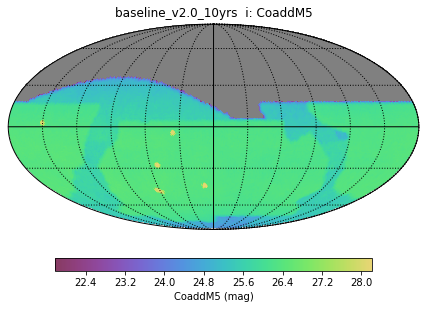

In [17]:
from IPython.display import Image


display(Image(full_fname))

# Making a new plot

To make a new plot that wasn't created in our batch run, we need to load the metric data itself into a new metric bundle.

Again, let's create an instance of `ResultsDB` that has our desired run:

In [18]:
run_name = "baseline_v2.0_10yrs"
out_dir = maf_data.set_index("simDataName").loc[run_name, "outDir"]
results_db = maf.ResultsDb(outDir=out_dir)

Start by asking the results database for the metric id corresponding to the one we want:

In [19]:
metric_name = "CoaddM5"
slicer_name = "HealpixSlicer"
metric_metadata = " i"

metric_ids = results_db.getMetricId(metric_name, slicer_name, metric_metadata, run_name)
metric_ids

[3]

This returned a list, because there could potentially have been more than one match. There's just one here, though, the one we want, so take it:

In [20]:
metric_id = metric_ids[0]

Use this `metric_id` to get metadata on the metric:

In [21]:
metric_info = results_db.getMetricInfo(metric_id)[0]

Extract the name of the data file, and tack on the directory so we have a file with a usable path:

In [22]:
fname = os.path.join(out_dir, metric_info["metricDataFile"])
fname

'/data/des91.b/data/neilsen/LSST/devel/rubin_sim_notebooks/maf/tutorial/bulk_metric_data/baseline_v2.0_10yrs/bulk_example/baseline_v2_0_10yrs_CoaddM5_i_HEAL.npz'

Create a new, empty bundle into which to load our data:

In [23]:
bundle = maf.createEmptyMetricBundle()

Actually load it:

In [24]:
bundle.read(fname)

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


Now we can adjust the plot functions and plotting parameters and replot, for example using a [Lambert Azimutha Equal-Area projection](https://en.wikipedia.org/wiki/Lambert_azimuthal_equal-area_projection):

0.0 180.0 -180.0 180.0
/data/des91.b/data/neilsen/anaconda/envs/rubin_sim/lib/python3.9/site-packages/healpy/projector.py:1080: RuntimeWarning: divide by zero encountered in true_divide
  kprime = np.sqrt(2.0 / (1.0 + np.cos(lat) * np.cos(phi)))
/data/des91.b/data/neilsen/anaconda/envs/rubin_sim/lib/python3.9/site-packages/healpy/projector.py:1085: RuntimeWarning: invalid value encountered in multiply
  y = kprime * np.sin(lat)


{'SkyMap': 1}

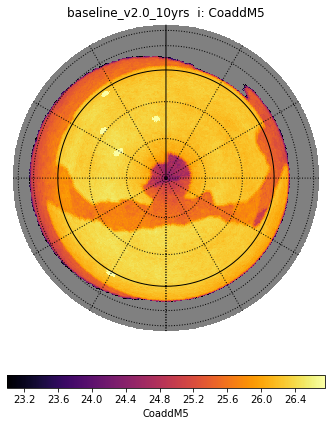

In [25]:
import matplotlib.pyplot as plt
import healpy as hp


plot_dict = {
    "rot": (0, -90, 0),
    "colorMin": 23,
    "colorMax": 26.75,
    "cmap": plt.get_cmap("inferno"),
    "visufunc": hp.azeqview,
    "lamb": True,
    "reso": 17.5,
    "figsize": (6, 6),
}
bundle.setPlotFuncs([maf.HealpixSkyMap()])
bundle.setPlotDict(plot_dict)
bundle.plot()

# Comparing runs

To compare runs, begin by creating an instance of `maf.RunComparison` that points to all of the relevant results databases:

In [26]:
run_names = maf_data.simDataName
run_comp = maf.RunComparison(data_dir, run_names)

Build a dictionory describing the various metrics that were run in the runs being compared:

In [27]:
metric_dict = run_comp.buildMetricDict()
metric_dict

{'OpenShutterFraction': {'metricName': 'OpenShutterFraction',
  'metricMetadata': '',
  'slicerName': 'UniSlicer'},
 'Count airmass  OneDSlicer': {'metricName': 'Count airmass',
  'metricMetadata': '',
  'slicerName': 'OneDSlicer'},
 'CoaddM5  i HealpixSlicer': {'metricName': 'CoaddM5',
  'metricMetadata': ' i',
  'slicerName': 'HealpixSlicer'},
 'CoaddM5  g HealpixSlicer': {'metricName': 'CoaddM5',
  'metricMetadata': ' g',
  'slicerName': 'HealpixSlicer'}}

Load the summary data for all of your runs to be compared:

In [28]:
run_comp.addSummaryStats(metric_dict)

In [29]:
summary_matrix = run_comp.summaryStats
summary_matrix

,OpenShutterFraction,Mean Count airmass OneDSlicer,Rms Count airmass OneDSlicer,Median Count airmass OneDSlicer,Max Count airmass OneDSlicer,Min Count airmass OneDSlicer,N(+3Sigma) Count airmass OneDSlicer,N(-3Sigma) Count airmass OneDSlicer,Count airmass OneDSlicer,25th%ile Count airmass OneDSlicer,75th%ile Count airmass OneDSlicer,Min CoaddM5 i HealpixSlicer,Median CoaddM5 i HealpixSlicer,Max CoaddM5 i HealpixSlicer,Min CoaddM5 g HealpixSlicer,Median CoaddM5 g HealpixSlicer,Max CoaddM5 g HealpixSlicer
baseline_nexp2_v1.7_10yrs,0.708027,68183.100000,133240.794104,6683.0,544349.0,258.0,1.0,0.0,30.0,1782.75,40629.25,26.174608,26.357288,28.201292,26.707464,26.902416,28.684006
baseline_2snaps_v1.5_10yrs,0.715772,68564.233333,128286.896405,8200.0,525350.0,188.0,1.0,0.0,30.0,2112.50,48478.75,26.130982,26.354405,28.190311,26.680652,26.905178,28.668771
baseline_v2.0_10yrs,0.722458,69566.000000,103403.912924,13391.5,365361.0,831.0,0.0,0.0,30.0,3339.00,99346.75,26.103001,26.287872,28.221760,26.662000,26.816838,28.721744
long_gaps_nightsoff3_delayed_1_v2.0_10yrs,0.719800,69310.966667,94606.351962,18966.5,326205.0,1057.0,0.0,0.0,30.0,4826.00,108710.50,26.076044,26.262196,28.213315,26.620265,26.779816,28.739500
footprint_4_v1.710yrs,0.706798,68056.966667,126946.444635,7375.5,510013.0,243.0,1.0,0.0,30.0,1705.50,49375.50,26.140961,26.349521,28.167579,26.666977,26.891383,28.670135
rolling_ns3_rw0.9_v2.0_10yrs,0.723845,69696.966667,96713.342535,17636.5,328708.0,1504.0,0.0,0.0,30.0,5586.25,105500.25,26.090283,26.260085,28.205212,26.633400,26.785035,28.734531


Lets pick a metric, and plot it against the different runs:

<AxesSubplot:xlabel='Median CoaddM5  g HealpixSlicer', ylabel='run_name'>

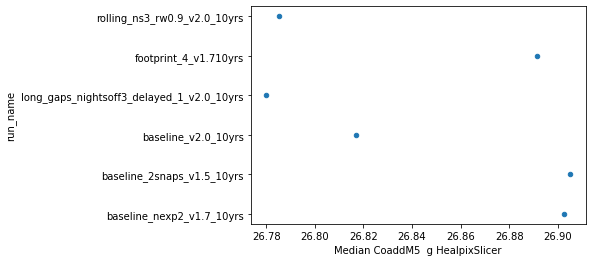

In [30]:
# make the DataFrame more self-documenting, and clarify plotting syntax
summary_matrix.index.name = "run_name"

summary_matrix.reset_index().plot.scatter("Median CoaddM5  g HealpixSlicer", "run_name")

If you want to compare many metrics on many runs, a mesh that gives all the values is useful:

/tmp/ipykernel_1929369/91560631.py:8: RuntimeWarning: invalid value encountered in true_divide
  norm_values = (summary_matrix.values - ref_values) / ref_values


(<Figure size 432x288 with 2 Axes>, <AxesSubplot:>)

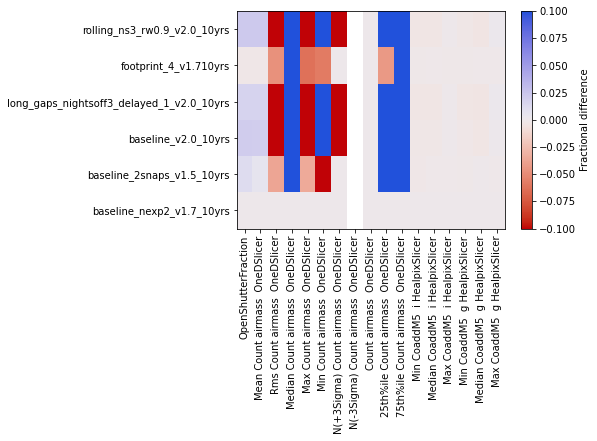

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import colorcet


def metric_mesh(summary_matrix, ref_run="baseline_nexp2_v1.7_10yrs", vrange=None):
    ref_values = summary_matrix.loc[ref_run].values
    norm_values = (summary_matrix.values - ref_values) / ref_values

    if vrange is None:
        vrange = 2 * max(np.max(norm_values), -1 * np.min(norm_values))

    vmin = -1 * vrange / 2
    vmax = vrange / 2

    fig, ax = plt.subplots()
    y_nums, x_nums = np.arange(summary_matrix.shape[0] + 1), np.arange(
        summary_matrix.shape[1] + 1
    )
    im = ax.pcolormesh(
        x_nums, y_nums, norm_values, vmin=vmin, vmax=vmax, cmap=colorcet.cm.coolwarm_r
    )

    ax.set_yticks(np.arange(0.5, summary_matrix.shape[0] + 0.5))
    if isinstance(summary_matrix.index[0], tuple):
        ax.set_yticklabels([", ".join(i) for i in summary_matrix.index])
    else:
        ax.set_yticklabels(summary_matrix.index)

    ax.set_xticks(np.arange(0.5, summary_matrix.shape[1] + 0.5))
    ax.set_xticklabels(summary_matrix.columns, rotation="vertical")

    fig.colorbar(im, ax=ax, label="Fractional difference")
    return fig, ax


metric_mesh(summary_matrix)

# Full metric comparison runs from many plots

If you want to compare the full metrics from many runs, not just the summary metrics, you will need to read the metric data itself:

In [32]:
metric_name = "Count airmass"
metric_metadata = ""
slicer_name = "OneDSlicer"
bundles, metric_name = run_comp.readMetricData(
    metric_name, metric_metadata, slicer_name
)

`bundles` is now a dictionary whose keys are run names, and whose values are metric bundles of the sort we asked for:

In [33]:
bundles

{'baseline_nexp2_v1.7_10yrs': <rubin_sim.maf.metricBundles.metricBundle.MetricBundle at 0x7f4fbdecbfa0>,
 'baseline_2snaps_v1.5_10yrs': <rubin_sim.maf.metricBundles.metricBundle.MetricBundle at 0x7f4fbdebe3d0>,
 'baseline_v2.0_10yrs': <rubin_sim.maf.metricBundles.metricBundle.MetricBundle at 0x7f4fbddbd7f0>,
 'long_gaps_nightsoff3_delayed_1_v2.0_10yrs': <rubin_sim.maf.metricBundles.metricBundle.MetricBundle at 0x7f4fbdd65430>,
 'footprint_4_v1.710yrs': <rubin_sim.maf.metricBundles.metricBundle.MetricBundle at 0x7f4fbdd65eb0>,
 'rolling_ns3_rw0.9_v2.0_10yrs': <rubin_sim.maf.metricBundles.metricBundle.MetricBundle at 0x7f4fbdd65d30>}

Now we can use our instance of `RunComparison` to plot the metrics from all of the runs together:

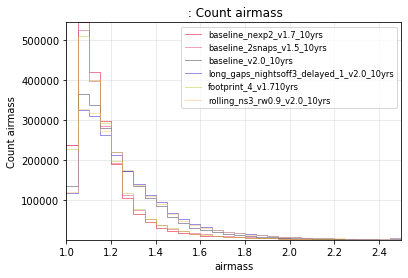

In [34]:
run_comp.plotMetricData(bundles, maf.OneDBinnedData())

We can do more complex replotting as well, including major changes to the plotting parameters. 

Let's look at a different metric, and replot it, but with parameter different from what we did originally:

First we need to actually load the metric data we are interested in:

In [35]:
metric_name = "CoaddM5"
metric_metadata = " i"
slicer_name = "HealpixSlicer"
bundles, metric_name = run_comp.readMetricData(
    metric_name, metric_metadata, slicer_name
)
bundles

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


{'baseline_nexp2_v1.7_10yrs': <rubin_sim.maf.metricBundles.metricBundle.MetricBundle at 0x7f4fbdde4e50>,
 'baseline_2snaps_v1.5_10yrs': <rubin_sim.maf.metricBundles.metricBundle.MetricBundle at 0x7f4fbd84dee0>,
 'baseline_v2.0_10yrs': <rubin_sim.maf.metricBundles.metricBundle.MetricBundle at 0x7f4fbd865c40>,
 'long_gaps_nightsoff3_delayed_1_v2.0_10yrs': <rubin_sim.maf.metricBundles.metricBundle.MetricBundle at 0x7f4fbd868940>,
 'footprint_4_v1.710yrs': <rubin_sim.maf.metricBundles.metricBundle.MetricBundle at 0x7f4fbd8682e0>,
 'rolling_ns3_rw0.9_v2.0_10yrs': <rubin_sim.maf.metricBundles.metricBundle.MetricBundle at 0x7f4fbd8681f0>}

You can do more complicated things with modifying plotting parameters and showing maps in grids:

0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
No handles with labels found to put in legend.


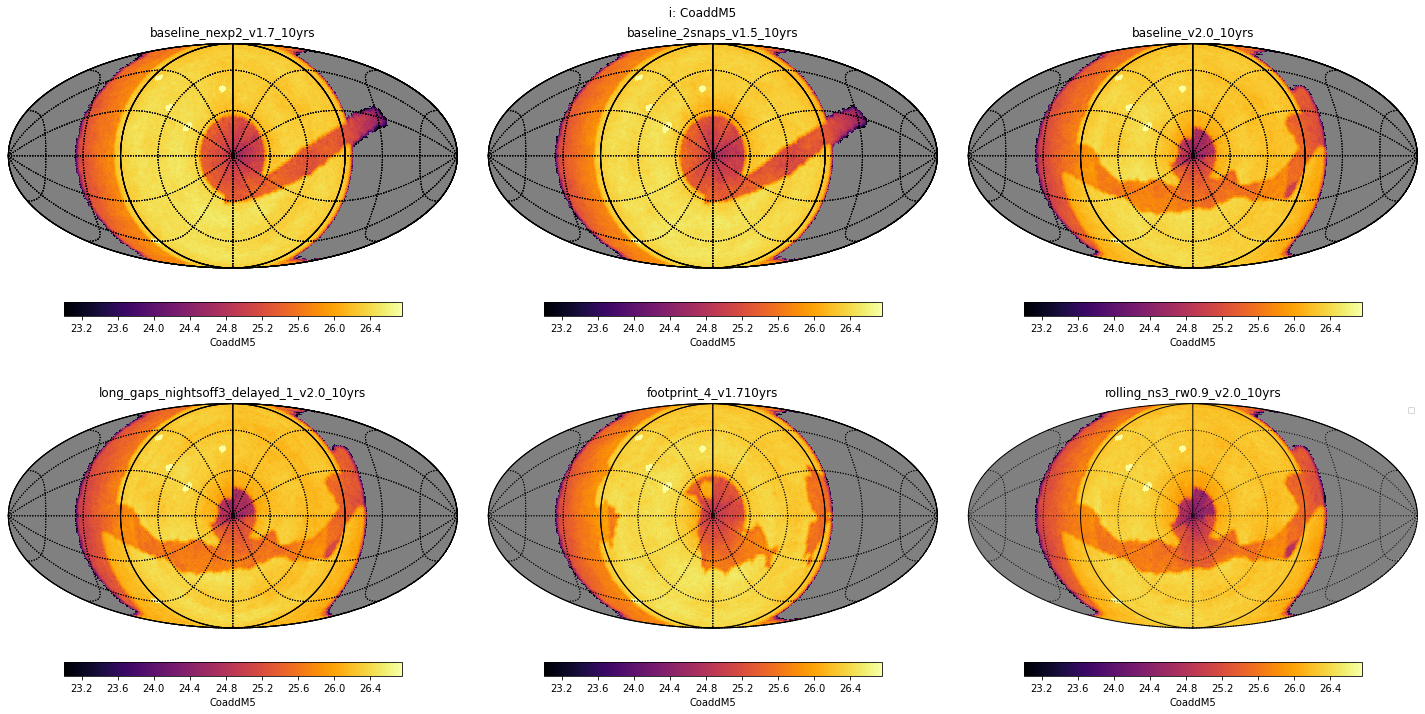

In [36]:
import matplotlib.pyplot as plt


plot_dict = {
    "rot": (0, -90, 0),
    "colorMin": 23,
    "colorMax": 26.75,
    "cmap": plt.get_cmap("inferno"),
    "figsize": (20, 10),
}
run_comp.plotMetricData(bundles, maf.HealpixSkyMap(), userPlotDict=plot_dict)

In [37]:
1

1